In [36]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [37]:
import numpy as np

In [38]:
from tidaldisruptionlrd import diffusion_coeff, eddington_inversion, utils
from tidaldisruptionlrd.constants import G

In [39]:
import importlib

importlib.reload(utils)
importlib.reload(eddington_inversion)
importlib.reload(diffusion_coeff)

<module 'tidaldisruptionlrd.diffusion_coeff' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/diffusion_coeff.py'>

In [40]:
class IsothermalSphereProfile(eddington_inversion.BaseProfile):
    def __init__(
        self,
        M_bh,
        sigma=None,
        r_bin_min_scaler=1e-7,
        r_bin_max_scaler=1e3,
        N_bins=10000,
    ):
        self.sigma = sigma or self._get_sigma(M_bh)
        self.r_h = G * M_bh / self.sigma**2
        super().__init__(
            r_bin_min=r_bin_min_scaler * self.r_h,
            r_bin_max=r_bin_max_scaler * self.r_h,
            N_bins=N_bins,
            M_bh=M_bh,
        )

    def _get_sigma(self, M_bh):
        return 200 * (M_bh / 1.48e8) ** (1 / 4.65)

    def _get_stellar_rho_bins(self, r_bins):
        return self.sigma**2 / (2 * np.pi * G * r_bins**2)

In [41]:
isothermal_sphere = IsothermalSphereProfile(M_bh=1e8, sigma=None)

Eddington's inversion:  86%|████████▋ | 8632/9999 [00:18<00:06, 209.01it/s]/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/eddington_inversion.py:151: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad(
Eddington's inversion: 100%|██████████| 9999/9999 [00:24<00:00, 411.53it/s]


In [42]:
reconstructed_stellar_rho_bins = isothermal_sphere.reconstruct_stellar_rho_bins()

/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/eddington_inversion.py:220: RuntimeWarning: divide by zero encountered in log
  self.eta_bins, np.log(self.f_eta_bins)
Reconstructing densities:   0%|          | 0/10000 [00:00<?, ?it/s]/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/eddington_inversion.py:229: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(_rho_integrand, 0, np.sqrt(-2 * phi), args=(-phi,))[0]
/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/eddington_inversion.py:229: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  lo

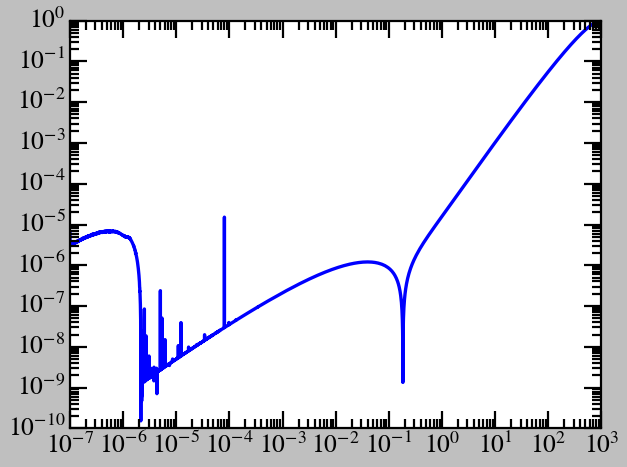

In [43]:
r_bins = isothermal_sphere.r_bins
r_h = isothermal_sphere.r_h
analytic_stellar_rho_bins = isothermal_sphere.stellar_rho_bins

plt.plot(
    r_bins / r_h, np.abs(1 - reconstructed_stellar_rho_bins / analytic_stellar_rho_bins)
)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

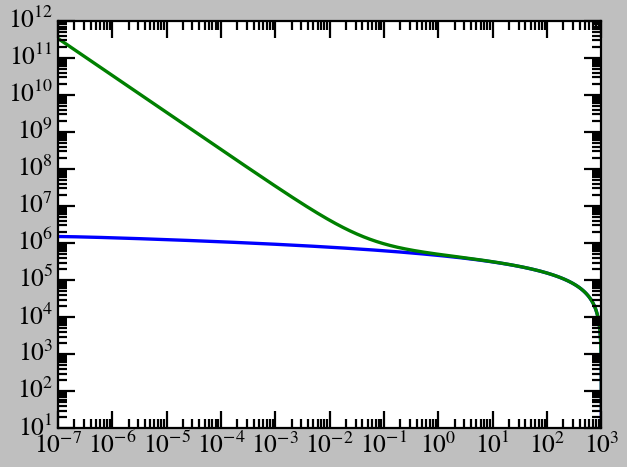

In [44]:
plt.plot(
    isothermal_sphere.r_bins / isothermal_sphere.r_h,
    -isothermal_sphere.stellar_phi_bins,
)
plt.plot(isothermal_sphere.r_bins / isothermal_sphere.r_h, -isothermal_sphere.phi_bins)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

In [45]:
importlib.reload(diffusion_coeff)

<module 'tidaldisruptionlrd.diffusion_coeff' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/diffusion_coeff.py'>

In [46]:
isothermal_diffusion_coeff = diffusion_coeff.DiffusionCoefficient(
    r_bins=isothermal_sphere.r_bins,
    phi_bins=isothermal_sphere.phi_bins,
    eta_bins=isothermal_sphere.eta_bins,
    f_eta_bins=isothermal_sphere.f_eta_bins,
)

/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/diffusion_coeff.py:114: RuntimeWarning: divide by zero encountered in log
  self.eta_bins, np.log(self.f_eta_bins)
Computing diffusion coefficients:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/diffusion_coeff.py:169: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  1/np.exp(_log_log_Jc_sqr_interp(np.log(_eta))) * quad(
Computing diffusion coefficients:  49%|████▉     | 493/1000 [00:09<00:11, 44.56it/s]/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/diffusion_coeff.py:169: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which ca

In [47]:
eta = 0.844
m_star = 1
r_star = 1 * 2.25461e-11

M_bh = isothermal_sphere.M_bh
sigma = isothermal_sphere.sigma

r_h = G * M_bh / sigma**2
r_t = (eta**2 * M_bh / m_star) ** (1 / 3) * r_star

In [48]:
psi_h = 2 * sigma**2 * np.log(isothermal_sphere._r_bin_max / r_h)

In [55]:
eta_h = -isothermal_sphere.phi_bins[np.argmin(np.abs(isothermal_sphere.r_bins - r_h))]

In [49]:
Jc_sqr_interp = isothermal_diffusion_coeff._get_Jc_sqr_interp()
Jlc_sqr = 2 * G * M_bh * r_t

Rlc = Jlc_sqr / np.exp(Jc_sqr_interp(np.log(isothermal_diffusion_coeff.eta_bins)))

In [50]:
Lambda = 0.4 * M_bh / m_star
scaler = 32 * np.pi**2 * G**2 * m_star**2 * np.log(Lambda) / 3

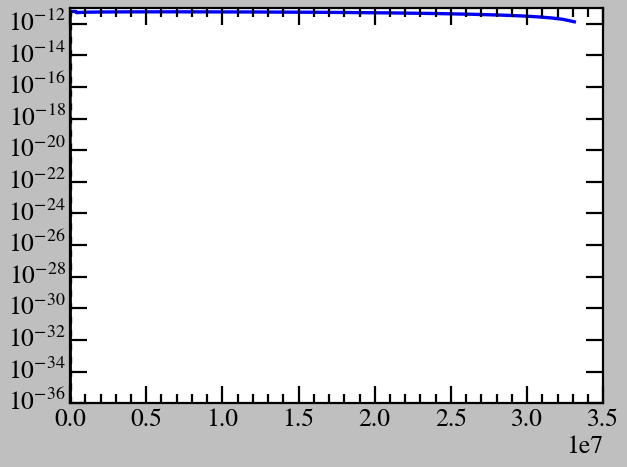

In [57]:
plt.plot(
    isothermal_diffusion_coeff.eta_bins / (100**2),
    Rlc * scaler * isothermal_diffusion_coeff.scaled_diff_coeff_bins,
)

plt.axvline(eta_h / (100**2), color="k", ls="--", label=r"$\eta_h$")

# plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()